In [1]:
import spacy
import pandas as pd
from google.cloud import language_v1
from google.oauth2 import service_account
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load("en_core_web_md")
creds = service_account.Credentials.from_service_account_file('./credentials.json')
client = language_v1.LanguageServiceClient(credentials=creds)

In [3]:
#test spacy
text = "This is a sentence."
print(len(text), "- délka textu jako řetězce znaků")
doc = nlp(text)
print(len(doc), "- délka textu jako sekvence tokenů")

19 - délka textu jako řetězce znaků
5 - délka textu jako sekvence tokenů


In [4]:
def getSentimentGoogle(text):
    language = "en"
    type_ = language_v1.Document.Type.PLAIN_TEXT
    encoding_type = language_v1.EncodingType.UTF8
    document = {"content": text, "type_": type_, "language": language}


    response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    score = response.document_sentiment.score
    return score


# Load data

In [5]:
df = pd.read_csv("Hotel_Reviews.csv")
df.info()
pd.options.mode.chained_assignment = None  # default='warn'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

# Vizualizace Dat 

Rozdělení průměrného skóre

<AxesSubplot:xlabel='sentiment', ylabel='count'>

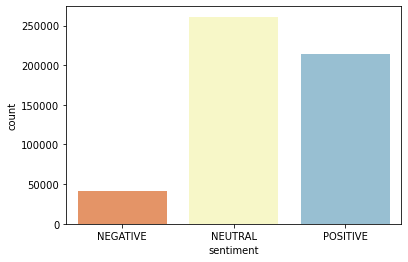

In [6]:
df["sentiment"] = pd.cut(df["Average_Score"], 
                   bins=[0,7.5,8.5,10], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=df, palette="RdYlBu")

<AxesSubplot:xlabel='Average_Score', ylabel='count'>

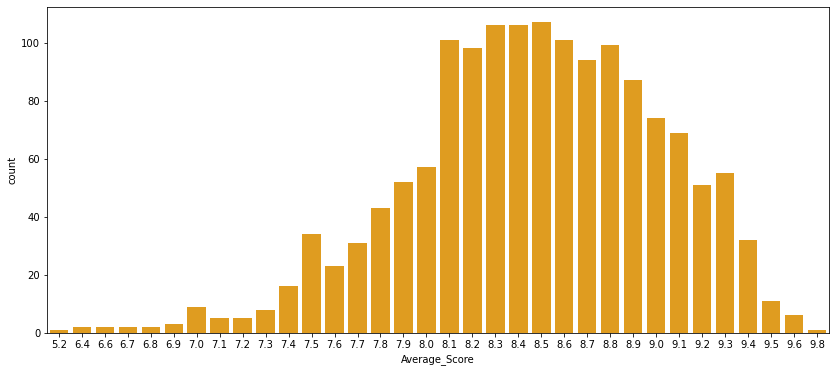

In [7]:
df_sd = df[['Hotel_Name','Average_Score']].drop_duplicates() 
plt.figure(figsize = (14,6))
sns.countplot(x = 'Average_Score',data = df_sd,color = 'orange')

Rozdělení hotelů podle lokace

<AxesSubplot:title={'center':'Hotel distribution in European countries'}>

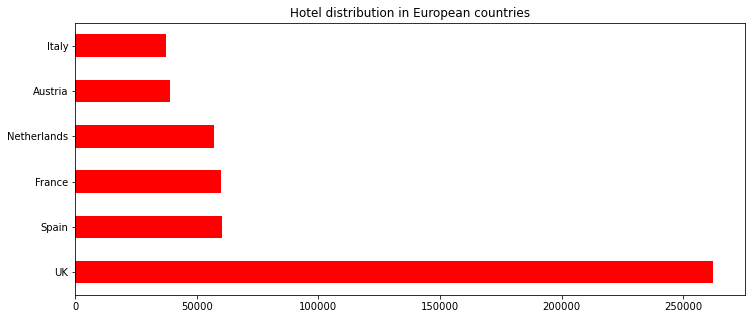

In [8]:
df.Hotel_Address = df.Hotel_Address.str.replace('United Kingdom','UK')
df['Country'] = df.Hotel_Address.apply(lambda x: x.split(' ')[-1])
 
plt.figure(figsize = (12,5))
plt.title('Hotel distribution in European countries')
df.Country.value_counts().plot.barh(color = 'red')

Korelační matice

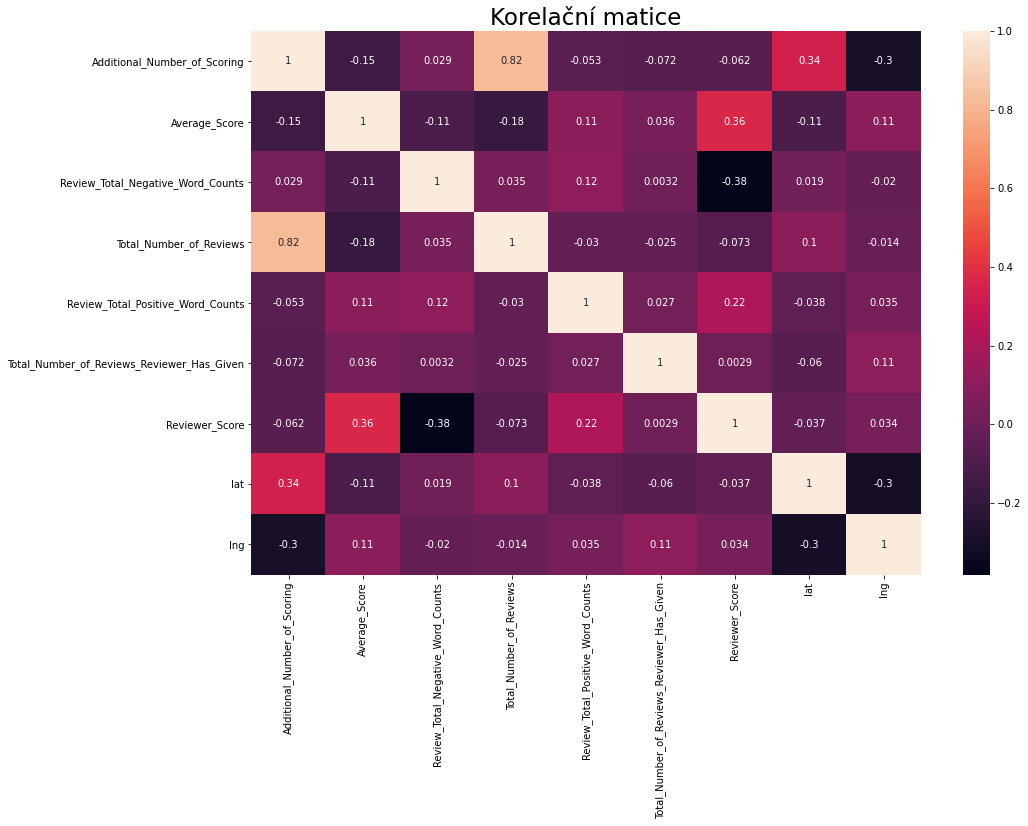

In [9]:
df_corr = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(df_corr, annot = True)
plt.title("Korelační matice", fontsize = 23)
plt.show()

Kontingenčí tabulka - medián a průměrné, minimální a maximální skóre hotelů

In [10]:
pd.pivot_table(df, 
               values="Average_Score", 
               aggfunc=["mean", "min", "max","median"], 
               index="Hotel_Name", 
               margins=True)

mean           min           max  \
                                   Average_Score Average_Score Average_Score   
Hotel_Name                                                                     
11 Cadogan Gardens                      8.700000           8.7           8.7   
1K Hotel                                7.700000           7.7           7.7   
25hours Hotel beim MuseumsQuartier      8.800000           8.8           8.8   
41                                      9.600000           9.6           9.6   
45 Park Lane Dorchester Collection      9.400000           9.4           9.4   
...                                          ...           ...           ...   
citizenM London Shoreditch              9.100000           9.1           9.1   
citizenM Tower of London                9.100000           9.1           9.1   
every hotel Piccadilly                  8.800000           8.8           8.8   
pentahotel Vienna                       8.500000           8.5           8.5   
All                                     8.397487           5.2           9.8   

                                          median  
                                   Average_Score  
Hotel_Name                                        
11 Cadogan Gardens                           8.7  
1K Hotel                                     7.7  
25hours Hotel beim MuseumsQuartier           8.8  
41                                           9.6  
45 Park Lane Dorchester Collection           9.4  
...                                          ...  
citizenM London Shoreditch                   9.1  
citizenM Tower of London                     9.1  
every hotel Piccadilly                       8.8  
pentahotel Vienna                            8.5  
All                                          8.4  

[1493 rows x 4 columns]

# Sentiment analysis pokus nad samplem

In [11]:
reviews = df[:50]
reviews["review"] = reviews["Negative_Review"] + reviews["Positive_Review"]
# create the label
reviews["bad_review"] = reviews["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews = reviews[["review", "bad_review"]]
pd.options.mode.chained_assignment = None  # default='warn'
reviews["review"] = reviews["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))
reviews.head()

googleSentiment = []
for i in reviews["review"].index:
    googleSentiment.append(getSentimentGoogle(reviews["review"][i]))

reviews['googleSentiment'] = googleSentiment


reviews.loc[ ( (reviews['bad_review'] == 1) & (reviews['googleSentiment'] > 0)), ['diff'] ] = 1
reviews.loc[ ( (reviews['bad_review'] == 0) & (reviews['googleSentiment'] < 0)), ['diff'] ] = 1
reviews.loc[ reviews['diff'] != 1, ['diff'] ] = 0


for i in reviews.loc[reviews['diff']==1, ['review'] ].index:
    print("Is it bad? ", reviews['bad_review'][i], "   ", reviews['review'][i], "\n")

PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #601999419145 by visiting https://console.developers.google.com/billing/enable?project=601999419145 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

In [12]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'sentiment', 'Country'],
      dtype='object')

In [13]:
#cleanDf = df[["Hotel_Name", "Average_Score", 'Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',"Reviewer_Score", 'Reviewer_Nationality', "Negative_Review", "Positive_Review", "Total_Number_of_Reviews_Reviewer_Has_Given", 'Review_Total_Negative_Word_Counts', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews','Tags', 'days_since_review' ]]
cleanDf = df

#len(cleanDf.index)
cleanDf.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng sentiment      Country  
0  52.360576  4.915968   NEUTRAL  Netherlands  
1  52.360576  4.915968   NEUTRAL  Netherlands  
2  52.360576  4.915968   NEUTRAL  Netherlands  
3  52.360576  4.915968   NEUTRAL  Netherlands  
4  52.360576  4.915968   NEUTRAL  Netherlands

# Rozdělení Tagů do sloupců

In [14]:
#Vytvoření sloupce Country

In [15]:
cleanDf.Hotel_Address = cleanDf.Hotel_Address.str.replace('United Kingdom','UK')
cleanDf['Country'] = cleanDf.Hotel_Address.apply(lambda x: x.split(' ')[-1])
cleanDf.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   
2   Location was good and staff were ok It is cut...   
3   Great location in nice surroundings the bar a...   
4    Amazing location and building Romantic setting    

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
2  [' Leisure trip ', ' Family with young childre...            3 days   
3  [' Leisure trip ', ' Solo traveler ', ' Duplex...            3 days   
4  [' Leisure trip ', ' Couple ', ' Suite ', ' St...           10 days   

         lat       lng sentiment      Country  
0  52.360576  4.915968   NEUTRAL  Netherlands  
1  52.360576  4.915968   NEUTRAL  Netherlands  
2  52.360576  4.915968   NEUTRAL  Netherlands  
3  52.360576  4.915968   NEUTRAL  Netherlands  
4  52.360576  4.915968   NEUTRAL  Netherlands

In [16]:
#Vytvoření sloupce Trip_type

In [17]:
cleanDf['Leisure_trip'] = cleanDf['Tags'].map(lambda x: "Leisure trip" if ' Leisure trip ' in x else "")
cleanDf['Business_trip'] = cleanDf['Tags'].map(lambda x: "Business trip" if ' Business trip ' in x else "")
cleanDf['Trip_type']=cleanDf['Leisure_trip']+cleanDf['Business_trip']
cleanDf.head

<bound method NDFrame.head of                                             Hotel_Address  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
...                                                   ...   
515733  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515734  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515735  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515736  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   
515737  Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
0                                194    8/3/2017            7.7   
1                                194    8/3/2017            7.7   
2                                194

In [18]:
#Vytvoření sloupce Trip_companions

In [19]:
cleanDf['Solo'] = cleanDf['Tags'].map(lambda x: "Solo traveler" if ' Solo traveler ' in x else "")
cleanDf['Group'] = cleanDf['Tags'].map(lambda x: "Group" if ' Group ' in x else "")
cleanDf['Couple'] = cleanDf['Tags'].map(lambda x: "Couple" if ' Couple ' in x else "")
cleanDf['Family1'] = cleanDf['Tags'].map(lambda x: "Family with young children" if ' Family with young children ' in x else "")
cleanDf['Family2'] = cleanDf['Tags'].map(lambda x: "Family with older children" if ' Family with older children' in x else "")
cleanDf['Friends'] = cleanDf['Tags'].map(lambda x: "Travelers with friends" if ' Travelers with friends ' in x else "")
cleanDf['Trip_companions']=cleanDf['Solo']+cleanDf['Group']+cleanDf['Couple']+cleanDf['Family1']+cleanDf['Family2']+cleanDf['Friends']

In [20]:
#Vytvoření sloupce Trip_duration

In [21]:
def splitString(string):
    array = string.split(" ', ' ")
    array[0] = array[0][3:]
    array[-1] = array[-1][:-3]
    if not 'trip' in array[0]:
        array.insert(0,None)
    try:
        return float(array[3].split()[1])
    except:
        return None

cleanDf["Nights"] = cleanDf["Tags"].apply(splitString)
Nights = pd.DataFrame(cleanDf, columns=['Nights'])

bins = [0, 1, 3 ,8 , 120]
labels = ['1 night', '2-3 nights', '4-7 nights', '8+ nights']
cleanDf["Trip_duration"] = pd.cut(Nights.Nights, bins, labels = labels,include_lowest = True)

# Vytvoření sloupce Pet

In [22]:
cleanDf['Pet'] = cleanDf['Tags'].map(lambda x: "yes" if 'With a pet ' in x else "no")
cleanDf.head()

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
3   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
4   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   
2                           194   7/31/2017            7.7  Hotel Arena   
3                           194   7/31/2017            7.7  Hotel Arena   
4                           194   7/24/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   
2           Australia    Rooms are nice but for elderly a bit difficul...   
3      United Kingdom    My room was dirty and I was afraid to walk ba...   
4         New Zealand    You When I booked with your company on line y...   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   
2                                 42                     1403   
3                                210                     1403   
4                                140                     1403   

                                     Positive_Review  ...           Solo  \
0   Only the park outside of the hotel was beauti...  ...                  
1   No real complaints the hotel was great great ...  ...                  
2   Location was good and staff were ok It is cut...  ...                  
3   Great location in nice surroundings the bar a...  ...  Solo traveler   
4    Amazing location and building Romantic setting   ...                  

   Group  Couple                     Family1 Family2  Friends  \
0         Couple                                                
1         Couple                                                
2                 Family with young children                    
3                                                               
4         Couple                                                

              Trip_companions Nights Trip_duration Pet  
0                      Couple    6.0    4-7 nights  no  
1                      Couple    4.0    4-7 nights  no  
2  Family with young children    3.0    2-3 nights  no  
3               Solo traveler    3.0    2-3 nights  no  
4                      Couple    2.0    2-3 nights  no  

[5 rows x 32 columns]

# Filtrace na mensi dataset pro NLP a Tokenizace sloupcu recenzi

In [23]:
unfiltered_cleanDf = cleanDf

In [26]:
cleanDf['days_since_review']

972        1 days
975       24 days
979       37 days
980       39 days
981       44 days
           ...   
512579    665 day
512618    458 day
512627    515 day
512629    520 day
512643    669 day
Name: days_since_review, Length: 14883, dtype: object

In [28]:
scoreMean = cleanDf["Average_Score"].mean()
scoreMedian = cleanDf["Average_Score"].median()
scoreMax =  cleanDf["Average_Score"].max()
print("Score mean: ", scoreMean)
print("Score median", scoreMedian)
print("Score max", scoreMax)
scoreToUse = 9

cleanDf = cleanDf.loc[cleanDf["Average_Score"] > scoreToUse]
print(len(cleanDf["Hotel_Name"].unique()), " Hotels left to recommend, reviews left: ", len(cleanDf.index))

cleanDf = cleanDf.loc[cleanDf['Review_Total_Negative_Word_Counts'] < 20]
cleanDf = cleanDf.loc[cleanDf['Review_Total_Positive_Word_Counts'] > 20]
len(cleanDf.index)
cleanDf = cleanDf.loc[cleanDf['Total_Number_of_Reviews'] > 100]
print(len(cleanDf["Hotel_Name"].unique()), " Hotels left to recommend, reviews left: ", len(cleanDf.index))

days_since_review = df["days_since_review"].str.slice(stop=1)
days_since_review = days_since_review.astype(int)
cleanDf["days_since_review"] = days_since_review
cleanDf = cleanDf.loc[cleanDf['days_since_review'] < 60]
print(len(cleanDf["Hotel_Name"].unique()), " Hotels left to recommend, reviews left: ", len(cleanDf.index))
cleanDf["Positive_Review"] = cleanDf["Positive_Review"].apply(lambda x: x.replace("No Positive", ""))
cleanDf["Negative_Review"] = cleanDf["Negative_Review"].apply(lambda x: x.replace("No Negative", ""))                                                              
cleanDf = cleanDf.loc[cleanDf['Positive_Review'] != ""]
cleanDf = cleanDf.loc[cleanDf['Total_Number_of_Reviews_Reviewer_Has_Given'] > 3 ]

print(len(cleanDf["Hotel_Name"].unique()), " Hotels left to recommend, reviews left: ", len(cleanDf.index))


Score mean:  9.229891156462422
Score median 9.2
Score max 9.8
213  Hotels left to recommend, reviews left:  7350
213  Hotels left to recommend, reviews left:  7350
213  Hotels left to recommend, reviews left:  7350
213  Hotels left to recommend, reviews left:  7350


In [29]:
# pridani tokenizovanych sloupcu negativnich recenzi
cleanDf['docN'] = [nlp(Negative_Review) for Negative_Review in cleanDf.Negative_Review]

# pridani tokenizovanych sloupcu pozitivnich recenzi
cleanDf['docP'] = [nlp(Positive_Review) for Positive_Review in cleanDf.Positive_Review]

cleanDf.sample(3)

Hotel_Address  \
482124  Via Mazzini 4 Milan City Center 20123 Milan Italy   
205753   50 rue des Bernardins 5th arr 75005 Paris France   
430439    Riudarenes 7 Ciutat Vella 08002 Barcelona Spain   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
482124                           133   1/13/2017            9.3   
205753                            67   9/22/2015            9.1   
430439                            43   5/22/2016            9.4   

                      Hotel_Name        Reviewer_Nationality  \
482124         UNA Maison Milano                     Poland    
205753        Residence Henri IV   United States of America    
430439  The Wittmore Adults Only                  Singapore    

                                          Negative_Review  \
482124   Cold bathroom But I received a heater Breakfa...   
205753   It s small It s very pricey given the amount ...   
430439                                                      

        Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
482124                                 15                     1108   
205753                                 14                      454   
430439                                  0                      217   

                                          Positive_Review  ...  Couple  \
482124   Big bed delicious breakfast Deborah and Ralf ...  ...           
205753   A well furnished and meticulously decorated l...  ...           
430439   This is a brand new hotel and has been extrem...  ...  Couple   

        Family1                     Family2 Friends  \
482124                                                
205753           Family with older children           
430439                                                

                   Trip_companions  Nights  Trip_duration Pet  \
482124               Solo traveler     2.0     2-3 nights  no   
205753  Family with older children     2.0     2-3 nights  no   
430439                      Couple     2.0     2-3 nights  no   

                                                     docN  \
482124  ( , Cold, bathroom, But, I, received, a, heate...   
205753  ( , It, s, small, It, s, very, pricey, given, ...   
430439                                                 ()   

                                                     docP  
482124  ( , Big, bed, delicious, breakfast, Deborah, a...  
205753  ( , A, well, furnished, and, meticulously, dec...  
430439  ( , This, is, a, brand, new, hotel, and, has, ...  

[3 rows x 34 columns]

# POS, tagging //sample doc

In [30]:
# nahodna recenze
sample_doc = cleanDf.docP[283235]
sample_doc[0:10]

 Rooms were spacious and very comfortable Staff are excellent

In [31]:
# POS (slovní druhy)
for token in sample_doc[0:10]:
    print (token.text, token.pos_)

  SPACE
Rooms NOUN
were AUX
spacious ADJ
and CCONJ
very ADV
comfortable ADJ
Staff NOUN
are AUX
excellent ADJ


In [32]:
# lemmatizace (zakladni tvary)
for token in sample_doc[0:10]:
    print (token.text, token.lemma_)

   
Rooms room
were be
spacious spacious
and and
very very
comfortable comfortable
Staff staff
are be
excellent excellent


In [33]:
# vypsání podstatných jmen v základním tvaru
print("Noun:", [token.lemma_ for token in sample_doc if token.pos_ == "NOUN"])

Noun: ['room', 'staff', 'area', 'bonus', 'drink', 'arrival', 'touch']


# Podstatná jména v negativních recenzích

In [34]:
newArray = []

# přidání negativních podstatných jmen v základním tvaru do pomocného array
for i, row in cleanDf.iterrows():
    dfReview = cleanDf.docN[i]
    newArray.append([token.lemma_ for token in dfReview if token.pos_ == "NOUN"])

# připojení pomocného array do nového sloupečku 'nounN' v dataframu 'cleanDf'
cleanDf["nounN"] = newArray

cleanDf.sample(3)

Hotel_Address  \
58050   151 157 City Road Shoreditch Islington London ...   
439271     San Sever 5 Ciutat Vella 08002 Barcelona Spain   
483850  Via Napo Torriani 18 Central Station 20124 Mil...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
58050                           1471   8/15/2016            9.1   
439271                            42   4/22/2017            9.2   
483850                           384    7/4/2016            9.2   

                                       Hotel_Name Reviewer_Nationality  \
58050   M by Montcalm Shoreditch London Tech City      United Kingdom    
439271                                 Hotel Neri              France    
483850                                Hotel Berna           Australia    

       Negative_Review  Review_Total_Negative_Word_Counts  \
58050                                                   0   
439271                                                  0   
483850                                                  0   

        Total_Number_of_Reviews  \
58050                      4802   
439271                      177   
483850                     4017   

                                          Positive_Review  ...  \
58050    This was my second time coming back to the Ho...  ...   
439271   The location is excellent easy to walk everyw...  ...   
483850   Great location close to Milano Centeale Amazi...  ...   

                           Family1  Family2  Friends  \
58050                                                  
439271  Family with young children                     
483850                                                 

                   Trip_companions  Nights  Trip_duration  Pet docN  \
58050                       Couple     1.0        1 night   no   ()   
439271  Family with young children     3.0     2-3 nights   no   ()   
483850               Solo traveler     1.0        1 night   no   ()   

                                                     docP nounN  
58050   ( , This, was, my, second, time, coming, back,...    []  
439271  ( , The, location, is, excellent, easy, to, wa...    []  
483850  ( , Great, location, close, to, Milano, Centea...    []  

[3 rows x 35 columns]

# Přídavná jména v negativních recenzích

In [35]:
newArray = []

# přidání negativních přídavných jmen v základním tvaru do pomocného array
for i, row in cleanDf.iterrows():
    dfReview = cleanDf.docN[i]
    newArray.append([token.lemma_ for token in dfReview if token.pos_ == "ADJ"])

# připojení pomocného array do nového sloupečku 'adjN' v dataframu 'cleanDf'
cleanDf["adjN"] = newArray

cleanDf.sample(3)

Hotel_Address  \
449613  Silvio Pellico 4 Milan City Center 20121 Milan...   
449774  Silvio Pellico 4 Milan City Center 20121 Milan...   
153708  336 337 Strand London Westminster Borough Lond...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
449613                           254   6/16/2017            9.3   
449774                           254    6/4/2016            9.3   
153708                           345   7/29/2016            9.2   

                Hotel_Name        Reviewer_Nationality  \
449613    Room Mate Giulia   United States of America    
449774    Room Mate Giulia                  Australia    
153708  ME London by Melia             United Kingdom    

                          Negative_Review  Review_Total_Negative_Word_Counts  \
449613   In our brief time there nothing                                   8   
449774                                                                     0   
153708                            nothing                                  2   

        Total_Number_of_Reviews  \
449613                     2011   
449774                     2011   
153708                     1017   

                                          Positive_Review  ...  \
449613   There just couldn t be a better location for ...  ...   
449774   The positive attitude of the staff matched up...  ...   
153708   staff were very attentive hotel extremely cle...  ...   

                           Family2  Friends             Trip_companions  \
449613                                                           Couple   
449774  Family with older children           Family with older children   
153708  Family with older children           Family with older children   

       Nights  Trip_duration  Pet                                       docN  \
449613    1.0        1 night   no  ( , In, our, brief, time, there, nothing)   
449774    1.0        1 night   no                                         ()   
153708    2.0     2-3 nights   no                               ( , nothing)   

                                                     docP   nounN     adjN  
449613  ( , There, just, couldn, t, be, a, better, loc...  [time]  [brief]  
449774  ( , The, positive, attitude, of, the, staff, m...      []       []  
153708  ( , staff, were, very, attentive, hotel, extre...      []       []  

[3 rows x 36 columns]

# Podstatná jména v pozitivních recenzích

In [36]:
newArray = []

# přidání pozitivních podstatných jmen v základním tvaru do pomocného array
for i, row in cleanDf.iterrows():
    dfReview = cleanDf.docP[i]
    newArray.append([token.lemma_ for token in dfReview if token.pos_ == "NOUN"])

# připojení pomocného array do nového sloupečku 'nounP' v dataframu 'cleanDf'
cleanDf["nounP"] = newArray

cleanDf.sample(3)

Hotel_Address  \
86185   2 8 Great Suffolk Street Southwark London SE1 ...   
185627  41 Buckingham Palace Road Westminster Borough ...   
322859  F hrichgasse 10 01 Innere Stadt 1010 Vienna Au...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
86185                            570   5/11/2016            9.3   
185627                            66   1/21/2016            9.6   
322859                           155  10/16/2016            9.4   

                    Hotel_Name Reviewer_Nationality Negative_Review  \
86185   Hilton London Bankside      United Kingdom          Nothing   
185627                      41           Australia                    
322859   The Guesthouse Vienna        Saudi Arabia                    

        Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
86185                                   2                     2319   
185627                                  0                      244   
322859                                  0                      951   

                                          Positive_Review  ...  Friends  \
86185    Very impressed with hotel staff and the locat...  ...            
185627   This is the most divine hotel we have stayed ...  ...            
322859   excellent location and professional staff Alw...  ...            

                   Trip_companions  Nights Trip_duration  Pet          docN  \
86185   Family with young children     2.0    2-3 nights   no  ( , Nothing)   
185627                      Couple     3.0    2-3 nights   no            ()   
322859               Solo traveler     2.0    2-3 nights   no            ()   

                                                     docP nounN adjN  \
86185   ( , Very, impressed, with, hotel, staff, and, ...    []   []   
185627  ( , This, is, the, most, divine, hotel, we, ha...    []   []   
322859  ( , excellent, location, and, professional, st...    []   []   

                                                    nounP  
86185     [hotel, staff, location, staff, morning, night]  
185627            [hotel, staff, people, location, money]  
322859  [location, staff, bed, coffee, machine, coffee...  

[3 rows x 37 columns]

# Přídavná jména v pozitivních recenzích

In [37]:
newArray = []

# přidání pozitivních přídavných jmen v základním tvaru do pomocného array
for i, row in cleanDf.iterrows():
    dfReview = cleanDf.docP[i]
    newArray.append([token.lemma_ for token in dfReview if token.pos_ == "ADJ"])

# připojení pomocného array do nového sloupečku 'adjP' v dataframu 'cleanDf'
cleanDf["adjP"] = newArray

cleanDf.sample(3)

Hotel_Address  \
272532         Arcs 10 Ciutat Vella 08002 Barcelona Spain   
49263   14 Rue du Chevalier de Saint George 1st arr 75...   
483660  Via Napo Torriani 18 Central Station 20124 Mil...   

        Additional_Number_of_Scoring Review_Date  Average_Score  \
272532                           247  10/13/2015            9.2   
49263                            127   7/16/2017            9.2   
483660                           384    5/7/2017            9.2   

                    Hotel_Name        Reviewer_Nationality  \
272532      Catalonia Catedral   United States of America    
49263   Hotel Op ra Richepanse   United States of America    
483660             Hotel Berna   United States of America    

             Negative_Review  Review_Total_Negative_Word_Counts  \
272532                                                        0   
49263                                                         0   
483660   No real complaints                                   5   

        Total_Number_of_Reviews  \
272532                     1914   
49263                      1073   
483660                     4017   

                                          Positive_Review  ...  \
272532   I had an AMAZING stay at the Catalonia Catedr...  ...   
49263    I was very happy during stay in this hotel be...  ...   
483660   From the moment we booked the reservation the...  ...   

        Trip_companions  Nights  Trip_duration Pet                       docN  \
272532    Solo traveler     2.0     2-3 nights  no                         ()   
49263            Couple     4.0     4-7 nights  no                         ()   
483660           Couple     1.0        1 night  no  ( , No, real, complaints)   

                                                     docP        nounN  \
272532  ( , I, had, an, AMAZING, stay, at, the, Catalo...           []   
49263   ( , I, was, very, happy, during, stay, in, thi...           []   
483660  ( , From, the, moment, we, booked, the, reserv...  [complaint]   

          adjN                                              nounP  \
272532      []  [stay, location, heart, district, minute, walk...   
49263       []  [stay, hotel, following, location, staff, serv...   
483660  [real]  [moment, reservation, hotel, room, bed, excell...   

                                                     adjP  
272532  [amazing, perfect, gothic, large, comfortable,...  
49263                                 [happy, good, good]  
483660  [interactive, sure, happy, fine, abundant, eas...  

[3 rows x 38 columns]

# Agregace recenzí podle hotelů

In [38]:
# vytvoření seznamu všech hotelů
uniqueHotelNames = cleanDf.Hotel_Name.unique()

In [39]:
# nový dataframe pro agregovane recenze podle hotelu
hotelAggregation = pd.DataFrame()

# přidání pozitivních a negativních podstatných jmen v základním tvaru k jednotlivým hotelům
i=0
for hotel in uniqueHotelNames:
    aggregateOfReviewsP = []
    aggregateOfReviewsN = [] 
    reviewsOfHotelP = cleanDf.loc[cleanDf["Hotel_Name"] == hotel, ["nounP"]]
    reviewsOfHotelN = cleanDf.loc[cleanDf["Hotel_Name"] == hotel, ["nounN"]]

    for review in reviewsOfHotelP["nounP"]:
        aggregateOfReviewsP.append(review)

    for review in reviewsOfHotelN["nounN"]:
        aggregateOfReviewsN.append(review)

    newRow = {"Hotel_Name" : hotel, "reviewsAggregateP" : aggregateOfReviewsP, "reviewsAggregateN" : aggregateOfReviewsN }
    hotelAggregation = hotelAggregation.append(newRow, ignore_index=True)


In [40]:
hotelAggregation

Hotel_Name  \
0           Apex Temple Court Hotel   
1                       One Aldwych   
2        Milestone Hotel Kensington   
3                   Haymarket Hotel   
4    Intercontinental London The O2   
..                              ...   
208               Park Hyatt Milano   
209          Strandhotel Alte Donau   
210        Hotel Kaiserin Elisabeth   
211          Corinthia Hotel London   
212                    The Berkeley   

                                     reviewsAggregateN  \
0    [[air, con], [], [], [job], [couple, time, sta...   
1         [[], [], [], [], [], [], [], [], [], [], []]   
2    [[], [], [], [], [], [night], [], [], [], [kno...   
3    [[], [], [], [], [], [], [bed, pillow], [], []...   
4    [[], [], [], [price, hike], [], [minute, compl...   
..                                                 ...   
208  [[], [], [gym], [], [], [hotel, location, rate...   
209                               [[], [], [], [], []]   
210  [[], [complaint, fruit, breakfast], [construct...   
211  [[bar, atmosphere], [], [], [], [massage], [],...   
212  [[night], [decoration, lobby, table, dining, o...   

                                     reviewsAggregateP  
0    [[location, room, check, walk, attraction, tra...  
1    [[wedding, night, staff, warmth, room, breakfa...  
2    [[property, staff, trouble, attention, detail,...  
3    [[staff, location, theatre, district, room, ai...  
4    [[hotel, hotel, bedroom, bathroom], [hotel, su...  
..                                                 ...  
208  [[hotel, quality, trip, expectation, staff, he...  
209  [[breakfast, property, min, train, station, pa...  
210  [[staff, property, museum, gallery, architectu...  
211  [[cigar, smoking, terrace, cigar, humidor, col...  
212  [[place, staff, doorman, welcome], [efficiency...  

[213 rows x 3 columns]

# Počet recenzí pro jednotlivé hotely

In [41]:
count = 0
i = 0
count=[]
arr=[]

# spočítání celkového počtu recenzí pro jednotlivé hotely
for i in range(len(hotelAggregation.reviewsAggregateP)):
    arr.append(len(hotelAggregation.reviewsAggregateP[i]))
    count=[]
hotelAggregation["numberOfReviews"] = arr

# Frekvence pozitivních slov

In [42]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'staff' v pozitivních recenzích
for i in range(len(hotelAggregation.reviewsAggregateP)):
    for j in range(len(hotelAggregation.reviewsAggregateP[i])):
        count.append(hotelAggregation.reviewsAggregateP[i][j].count("staff"))
    arr.append(sum(count))
    count=[]
hotelAggregation["staffPCount"] = arr

In [43]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'location' v pozitivních recenzích
for i in range(len(hotelAggregation.reviewsAggregateP)):
    for j in range(len(hotelAggregation.reviewsAggregateP[i])):
        count.append(hotelAggregation.reviewsAggregateP[i][j].count("location"))
    arr.append(sum(count))
    count=[]
hotelAggregation["locationPCount"] = arr

In [44]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'room' v pozitivních recenzích
for i in range(len(hotelAggregation.reviewsAggregateP)):
    for j in range(len(hotelAggregation.reviewsAggregateP[i])):
        count.append(hotelAggregation.reviewsAggregateP[i][j].count("room"))
    arr.append(sum(count))
    count=[]
hotelAggregation["roomPCount"] = arr

# Frekvence negativních slov

In [45]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'staff' v negativních recenzích
for i in range(len(hotelAggregation.reviewsAggregateN)):
    for j in range(len(hotelAggregation.reviewsAggregateN[i])):
        count.append(hotelAggregation.reviewsAggregateN[i][j].count("staff"))
    arr.append(sum(count))
    count=[]
hotelAggregation["staffNCount"] = arr

In [46]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'air' v negativních recenzích
for i in range(len(hotelAggregation.reviewsAggregateN)):
    for j in range(len(hotelAggregation.reviewsAggregateN[i])):
        count.append(hotelAggregation.reviewsAggregateN[i][j].count("air"))
    arr.append(sum(count))
    count=[]
hotelAggregation["airNCount"] = arr

In [47]:
count = 0
i = 0
j=0
count=[]
arr=[]

# počet objevení slova 'pool' v negativních recenzích
for i in range(len(hotelAggregation.reviewsAggregateN)):
    for j in range(len(hotelAggregation.reviewsAggregateN[i])):
        count.append(hotelAggregation.reviewsAggregateN[i][j].count("pool"))
    arr.append(sum(count))
    count=[]
hotelAggregation["poolNCount"] = arr

# Wordcloud

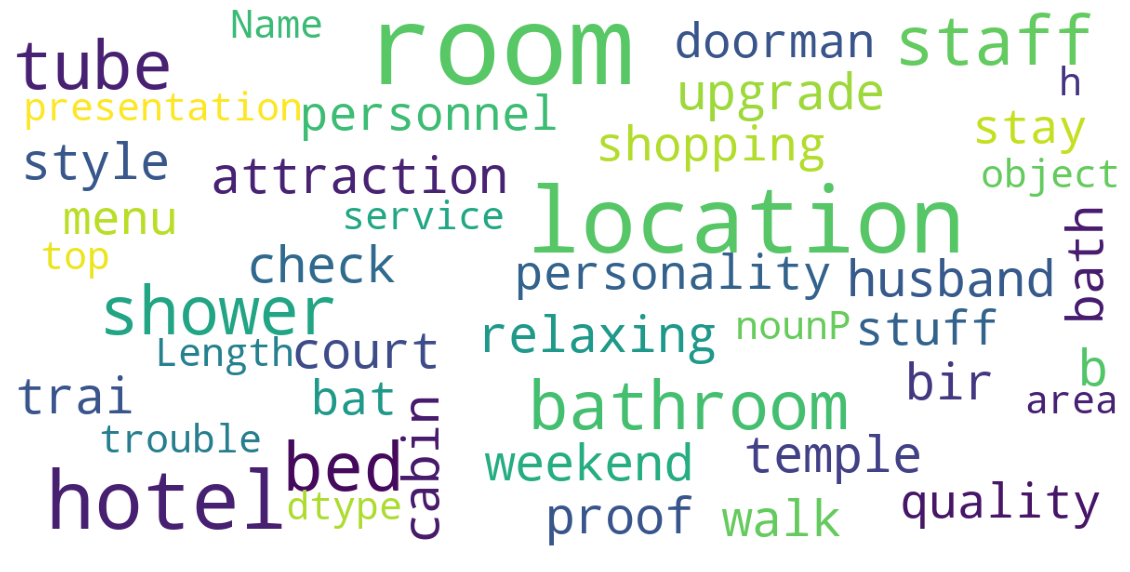

In [48]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud

show_wordcloud(cleanDf["nounP"]) # word cloud pro slova v pozitivních recenzích

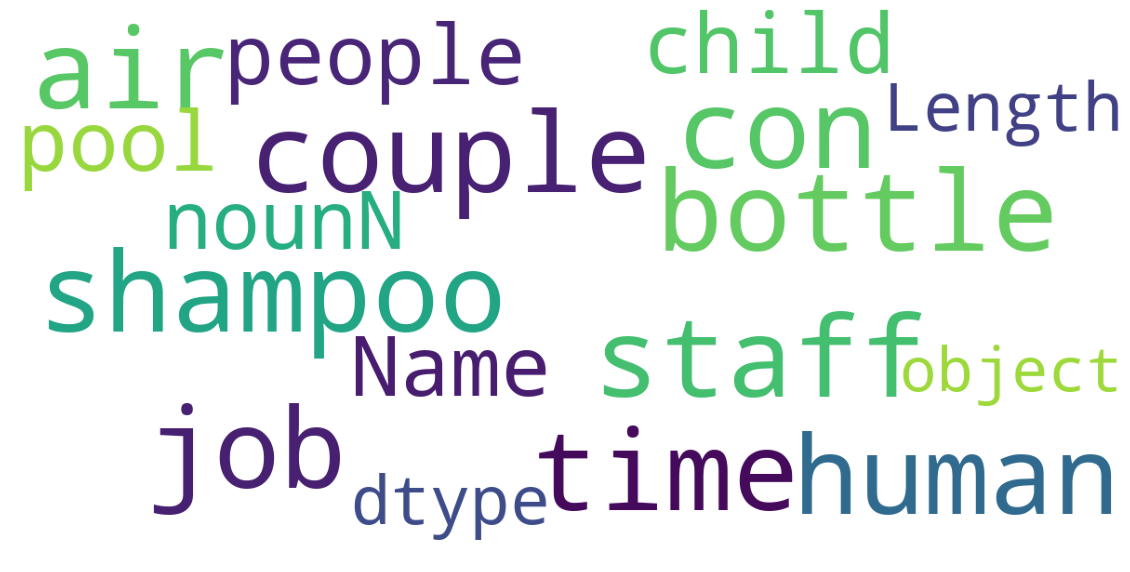

In [49]:
show_wordcloud(cleanDf["nounN"]) # word cloud pro slova v negativních recenzích


In [50]:
# positiveDictionary = ['location', 'staff', 'room']
# negativeDictionary = ['air', 'pool', 'staff']

# Tagy

In [51]:
import numpy as np

### Pozitivní

In [52]:
hotelAggregation["staffPTag"] = np.where(hotelAggregation["staffPCount"] > (hotelAggregation["numberOfReviews"]/2), 1, 0)

In [53]:
hotelAggregation["locationPTag"] = np.where(hotelAggregation["locationPCount"] > (hotelAggregation["numberOfReviews"]/4), 1, 0)

In [54]:
hotelAggregation["roomPTag"] = np.where(hotelAggregation["roomPCount"] > (hotelAggregation["numberOfReviews"]/2), 1, 0)

### Negativní

In [55]:
hotelAggregation["staffNTag"] = np.where(hotelAggregation["staffNCount"] > 0, 1, 0)

In [56]:
hotelAggregation["airNTag"] = np.where(hotelAggregation["airNCount"] > 0, 1, 0)

In [57]:
hotelAggregation["poolNTag"] = np.where(hotelAggregation["poolNCount"] > 0, 1, 0)

# Add columns from Tags to aggregation

In [58]:
newCols_HotelAggregation = ['Trip_type','Trip_companions','Trip_duration','Pet']
cleanDf.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'sentiment', 'Country',
       'Leisure_trip', 'Business_trip', 'Trip_type', 'Solo', 'Group', 'Couple',
       'Family1', 'Family2', 'Friends', 'Trip_companions', 'Nights',
       'Trip_duration', 'Pet', 'docN', 'docP', 'nounN', 'adjN', 'nounP',
       'adjP'],
      dtype='object')

In [61]:
newRow = {}
haggr = pd.DataFrame()
uniqueHotels = cleanDf["Hotel_Name"].unique()
for hotel in uniqueHotels:
    varDF = cleanDf.loc[cleanDf['Hotel_Name'] == hotel]
    #numOfReviews = len(varDF)
    for col in newCols_HotelAggregation:
       count = df[col].value_counts() 
       mostCommonAttr = count.index[0]
       mostCommonValue = count[0]
       newRow['most common reviews by: ' + col] = mostCommonAttr
      
    haggr = haggr.append(newRow, ignore_index=True)          
haggr   

most common reviews by: Pet most common reviews by: Trip_companions  \
0                            no                                  Couple   
1                            no                                  Couple   
2                            no                                  Couple   
3                            no                                  Couple   
4                            no                                  Couple   
..                          ...                                     ...   
208                          no                                  Couple   
209                          no                                  Couple   
210                          no                                  Couple   
211                          no                                  Couple   
212                          no                                  Couple   

    most common reviews by: Trip_duration most common reviews by: Trip_type  
0                              2-3 nights                      Leisure trip  
1                              2-3 nights                      Leisure trip  
2                              2-3 nights                      Leisure trip  
3                              2-3 nights                      Leisure trip  
4                              2-3 nights                      Leisure trip  
..                                    ...                               ...  
208                            2-3 nights                      Leisure trip  
209                            2-3 nights                      Leisure trip  
210                            2-3 nights                      Leisure trip  
211                            2-3 nights                      Leisure trip  
212                            2-3 nights                      Leisure trip  

[213 rows x 4 columns]

In [62]:
hotelAggregation['PetFriendly'] = haggr['most common reviews by: Pet']
hotelAggregation['IdealFor'] = haggr['most common reviews by: Trip_companions']
hotelAggregation['IdealStay'] = haggr['most common reviews by: Trip_duration']
hotelAggregation['IdealTripType'] = haggr['most common reviews by: Trip_type']


In [63]:
hotelAggregation

Hotel_Name  \
0           Apex Temple Court Hotel   
1                       One Aldwych   
2        Milestone Hotel Kensington   
3                   Haymarket Hotel   
4    Intercontinental London The O2   
..                              ...   
208               Park Hyatt Milano   
209          Strandhotel Alte Donau   
210        Hotel Kaiserin Elisabeth   
211          Corinthia Hotel London   
212                    The Berkeley   

                                     reviewsAggregateN  \
0    [[air, con], [], [], [job], [couple, time, sta...   
1         [[], [], [], [], [], [], [], [], [], [], []]   
2    [[], [], [], [], [], [night], [], [], [], [kno...   
3    [[], [], [], [], [], [], [bed, pillow], [], []...   
4    [[], [], [], [price, hike], [], [minute, compl...   
..                                                 ...   
208  [[], [], [gym], [], [], [hotel, location, rate...   
209                               [[], [], [], [], []]   
210  [[], [complaint, fruit, breakfast], [construct...   
211  [[bar, atmosphere], [], [], [], [massage], [],...   
212  [[night], [decoration, lobby, table, dining, o...   

                                     reviewsAggregateP  numberOfReviews  \
0    [[location, room, check, walk, attraction, tra...              118   
1    [[wedding, night, staff, warmth, room, breakfa...               11   
2    [[property, staff, trouble, attention, detail,...               13   
3    [[staff, location, theatre, district, room, ai...               15   
4    [[hotel, hotel, bedroom, bathroom], [hotel, su...              131   
..                                                 ...              ...   
208  [[hotel, quality, trip, expectation, staff, he...               13   
209  [[breakfast, property, min, train, station, pa...                5   
210  [[staff, property, museum, gallery, architectu...               60   
211  [[cigar, smoking, terrace, cigar, humidor, col...               24   
212  [[place, staff, doorman, welcome], [efficiency...                9   

     staffPCount  locationPCount  roomPCount  staffNCount  airNCount  \
0             54              56          94            2          1   
1             10               3           6            0          0   
2             13               2           6            0          0   
3              8               7          13            0          0   
4             77              31          68            0          0   
..           ...             ...         ...          ...        ...   
208            8               7           9            0          0   
209            2               1           5            0          0   
210           44              40          33            0          0   
211            8               7           9            1          0   
212            5               3           4            0          0   

     poolNCount  staffPTag  locationPTag  roomPTag  staffNTag  airNTag  \
0             0          0             1         1          1        1   
1             0          1             1         1          0        0   
2             0          1             0         0          0        0   
3             0          1             1         1          0        0   
4             1          1             0         1          0        0   
..          ...        ...           ...       ...        ...      ...   
208           0          1             1         1          0        0   
209           0          0             0         1          0        0   
210           0          1             1         1          0        0   
211           0          0             1         0          1        0   
212           1          1             1         0          0        0   

     poolNTag PetFriendly IdealFor   IdealStay IdealTripType  
0           0          no   Couple  2-3 nights  Leisure trip  
1           0          no   Couple  2-3 nights  Leisure trip  
2           0  

In [64]:
hotelAggregation.columns

Index(['Hotel_Name', 'reviewsAggregateN', 'reviewsAggregateP',
       'numberOfReviews', 'staffPCount', 'locationPCount', 'roomPCount',
       'staffNCount', 'airNCount', 'poolNCount', 'staffPTag', 'locationPTag',
       'roomPTag', 'staffNTag', 'airNTag', 'poolNTag', 'PetFriendly',
       'IdealFor', 'IdealStay', 'IdealTripType'],
      dtype='object')

In [65]:
len(cleanDf)

7350

# Filtrace jen na potřebné sloupce + debugging


In [73]:
cleanDf_columnsToUse = ['Hotel_Name','Hotel_Address','Average_Score','Trip_type','Trip_companions','Nights','Pet_friendly']
hotelAggregation.columns

Index(['Hotel_Name', 'reviewsAggregateN', 'reviewsAggregateP',
       'numberOfReviews', 'staffPCount', 'locationPCount', 'roomPCount',
       'staffNCount', 'airNCount', 'poolNCount', 'staffPTag', 'locationPTag',
       'roomPTag', 'staffNTag', 'airNTag', 'poolNTag', 'PetFriendly',
       'IdealFor', 'IdealStay', 'IdealTripType', 'Hotel_Address'],
      dtype='object')

In [74]:
hotelAggregation_columnsToUse = ['Hotel_Name','Hotel_Address','numberOfReviews', 'PetFriendly','IdealFor','IdealStay','IdealTripType', 'staffPTag','locationPTag','roomPTag','staffNTag','airNTag','poolNTag']
for val in hotelAggregation_columnsToUse:
    if val not in hotelAggregation.columns :
        print(val)
#hotelAggregation[hotelAggregation_columnsToUse]


In [1]:
uniqueHotels = cleanDf["Hotel_Name"].unique()
adress = []
for hotel in uniqueHotels:
    varDF = cleanDf.loc[cleanDf['Hotel_Name'] == hotel]
    adress.append(varDF['Hotel_Address'].replace(',', ' '))
hotelAggregation['Hotel_Address'] = adress

hotelAggregation=hotelAggregation.drop(columns = ['Unnamed: 0'])

NameError: name 'cleanDf' is not defined

In [8]:
# dodatecny debugging carek v adresach
import pandas as pd 
hotelAggregation = pd.read_csv("hotelAggregation.csv")
adress = []
for val in hotelAggregation['Hotel_Address']:
    adress.append(hotelAggregation['Hotel_Address'].replace(',', ' '))
hotelAggregation['Hotel_Address'] = adress    
hotelAggregation.to_csv('D:/hotelAggregation.csv')

In [6]:
hotelAggregationFinal = hotelAggregation[hotelAggregation_columnsToUse]

NameError: name 'hotelAggregation_columnsToUse' is not defined

In [77]:
cleanDf.to_csv('D:/cleanDf.csv')
unfiltered_cleanDf.to_csv('D:/unfiltered_cleanDf.csv')

In [78]:
hotelAggregationFinal.to_csv('D:/hotelAggregation.csv')